# FIR Filter Oscillation

## Pyro Instantiation

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.pyro import make_proxy

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,10)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_3cde8b18d45b4d708deec1c942f4b4c0@192.168.2.99:34289


## Program

In [116]:
class MultiPulseLoopBackExample(AveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        self.phrst  = cfg["phrst"]
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = cfg["pulse_time"] + 100,       # Readout length
            number_of_trace_average = cfg["reps"]
        )
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = 16, # Readout DDS multiplication length
            phrst   = self.phrst# Readout DDS phase reset
        )
        self.synci(100)

    def body(self):
        cfg = self.cfg
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 101 # Readout will capture the data @ sync_t + 50
        )
        self.setup_and_pulse(
            ch      = 0,        # Generator channel
            style   = "const",    # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = int(15000), # Generator amplitude
            phrst   = self.phrst,# Generator DDS phase reset
            length  = cfg["pulse_time"],
            t       = 100
        )
        self.sync_all(1000)

## Phrst = False

Acquisition time for 100000 averages: 0.6743049621582031 s


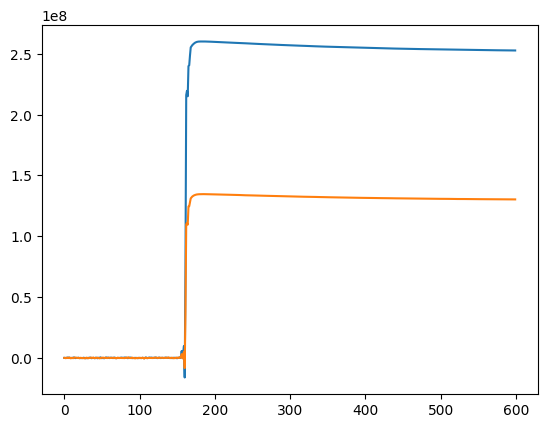


// Program

        regwi 4, $22, 1072847039;               //freq = 4291388156
        bitwi 4, $22, $22 << 2;
        regwi 4, $26, 500;                      //mode | outsel = 0b00000 | length = 500 
        synci 100;
        regwi 0, $15, 0;
        regwi 0, $14, 49999;
LOOP_J: regwi 4, $27, 100;                      //t = 100
        set 4, 4, $22, $0, $26, $0, $26, $27;   //ch = 0, pulse @t = $27
        regwi 0, $16, 1;                        //out = 0b0000000000000001
        seti 7, 0, $16, 101;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 111;                     //ch =0 out = 0 @t = 0
        regwi 0, $22, 536423519;                //freq = 2145694078
        bitwi 0, $22, $22 << 2;
        mathi 0, $22, $22 + 2;
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 15000;                    //gain = 15000
        regwi 0, $26, 590324;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 500 
        reg

In [113]:
cfg = {
    # Experiment Setup
    "reps" : 50000,
    "expts" : 1,
    # Parameter Setup
    "freq_rf" : 2398,
    "pulse_time" : 500,
    "phrst" : 0,
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = 1
start_time = time.time()
data = (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
for i in range(LEN):
    data += (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
end_time = time.time()

print(f"Acquisition time for {cfg['reps']*(LEN+1)} averages: {end_time - start_time} s")
plt.figure()
plt.plot(data)
plt.show()

print(prog)

## Phrst = True

Acquisition time for 100000 averages: 0.5849654674530029 s


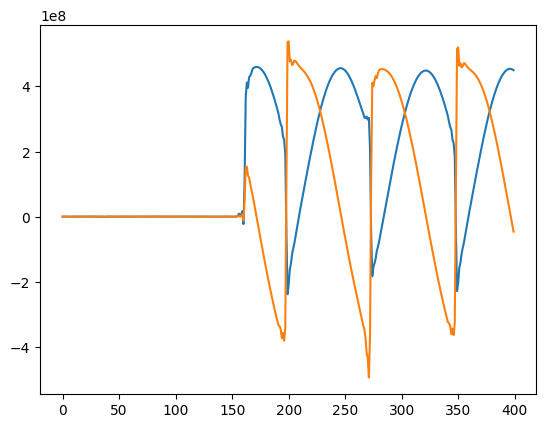


// Program

        regwi 4, $22, 1072847039;               //freq = 4291388156
        bitwi 4, $22, $22 << 2;
        regwi 4, $26, 524304;                   //mode | outsel = 0b01000 | length = 16 
        synci 100;
        regwi 0, $15, 0;
        regwi 0, $14, 49999;
LOOP_J: regwi 4, $27, 100;                      //t = 100
        set 4, 4, $22, $0, $26, $0, $26, $27;   //ch = 0, pulse @t = $27
        regwi 0, $16, 1;                        //out = 0b0000000000000001
        seti 7, 0, $16, 101;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 111;                     //ch =0 out = 0 @t = 0
        regwi 0, $22, 536423519;                //freq = 2145694078
        bitwi 0, $22, $22 << 2;
        mathi 0, $22, $22 + 2;
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 15000;                    //gain = 15000
        regwi 0, $26, 1638700;                  //phrst| stdysel | mode | | outsel = 0b11001 | length = 300 
        regw

In [117]:
cfg = {
    # Experiment Setup
    "reps" : 50000,
    "expts" : 1,
    # Parameter Setup
    "freq_rf" : 2398,
    "pulse_time" : 300,
    "phrst" : 1,
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = 1
start_time = time.time()
data = (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
for i in range(LEN):
    data += (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
end_time = time.time()

print(f"Acquisition time for {cfg['reps']*(LEN+1)} averages: {end_time - start_time} s")
plt.figure()
plt.plot(data)
plt.show()

print(prog)